In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import glob
import PIL
import webdataset as wds
import os
import os.path
import io
from ocrlib import extract_seg
from random import randrange
import scipy.ndimage as ndi

# Convert Raw UW3 Data to Usable JSON

In [3]:
def getboxes(text, target):
    if isinstance(text, bytes): text = text.decode("utf-8")
    lines = [l.strip() for l in text.split("\n")]
    result = []
    for l in lines:
        if (len(l)==5 and "=" not in l) or l == "":
            doc = None
            zone = None
            continue
        #print(l)
        k, v = re.split(" *= *", l, maxsplit=1)
        if k == "ZONE_ID":
            zone = v
        elif k== "DOCUMENT_ID":
            doc = v
        elif k == target:
            box = [int(x) for x in v.split()]
            result.append(dict(box=box, zone=zone, doc=doc))
        else:
            raise ValueError(f"{k}: {v} unknown")
    return result

In [4]:
orig = next(iter(wds.Dataset("uw3/uw3-original.tar").decode()))
orig.keys()

dict_keys(['__key__', '1cond.txt', '1ground.txt', '1pageattr.txt', '1pageboxs.txt', '1zoneattr.txt', '1zoneboxs.txt', 'dafs', 'dafs.txt', 'image.tif', 'labzones.txt', 'linebox.txt', 'wordbox.txt', 'zonebox.txt'])

In [5]:
def parse_zone_attr(attr):
    if isinstance(attr, bytes):
        attr = attr.decode("utf-8")
    result = []
    r = None
    for line in attr.split("\n"):
        line = line.strip()
        if line == "":
            continue
        if line == "ZZZZZ":
            if r is not None:
                result.append(r)
            r = dict()
            continue
        F = [x.strip() for x in line.split("=", 1)]
        r[F[0]] = F[1]
    result.append(r)
    return result

def parse_zone_boxes(text):
    if isinstance(text, bytes):
        text = text.decode("utf-8")
    result = []
    r = None
    for line in text.split("\n"):
        line = line.strip()
        if line == "":
            continue
        if line == "BBBBB":
            if r is not None:
                result.append(r)
            r = dict()
            continue
        F = [x.strip() for x in line.split("=", 1)]
        r[F[0]] = F[1]
    result.append(r)
    return result


def parse_zones(orig):
    if "zonebox.txt" not in orig or "1zoneattr.txt" not in orig:
        return None
    boxes = parse_zone_boxes(orig["zonebox.txt"])
    attr = parse_zone_attr(orig["1zoneattr.txt"])
    attr = {a["ZONE_ID"]: a for a in attr}
    for b in boxes:
        a = attr[b["ZONE_ID"]]
        assert a["PAGE_ID"] == b["DOCUMENT_ID"]
        assert a["ZONE_ID"] == b["ZONE_ID"]
        x0, y0 = map(int, b["CORNER_ONE_RC"].split())
        x1, y1 = map(int, b["CORNER_TWO_RC"].split())
        b["box"] = [y0, y1, x0, x1]
        b.update(a)
    return boxes

parse_zones(orig)[:1]

[{'DOCUMENT_ID': 'A001',
  'ZONE_ID': '000',
  'CORNER_ONE_RC': '799 195',
  'CORNER_TWO_RC': '1600 231',
  'box': [195, 231, 799, 1600],
  'PAGE_ID': 'A001',
  'ZONE_CONTENT': 'text',
  'ZONE_TYPE': 'page-header',
  'TEXT_ALIGNMENT': 'justified',
  'CHARACTER_ORIENTATION': 'up-right',
  'DOMINANT_FONT_TYPE': 'serif',
  'DOMINANT_FONT_SPACING': 'proportional',
  'DOMINANT_FONT_SIZE': '9-12',
  'DOMINANT_FONT_STYLE': 'plain',
  'TEXT_READING_DIRECTION': 'left-right',
  'LANGUAGE': 'English',
  'SCRIPT': 'Roman',
  'COLUMN_NUMBER': 'header-area',
  'NEXT_SEMANTICAL_ZONE': 'nil'}]

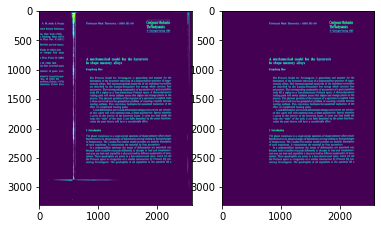

In [6]:
def pagebox(sample):
    locations = sample["zonebox.txt"]
    locations = locations if isinstance(locations, str) else locations.decode("utf-8")
    locations = locations.split("\n")
    locations = [x for x in locations if "_RC" in x]
    locations = [re.split(" *= *", x)[1] for x in locations]
    locations = array([[int(s) for s in x.split()] for x in locations])
    x0, y0 = amin(locations, axis=0)
    x1, y1 = amax(locations, axis=0)
    return x0, y0, x1, y1

def getimage(sample):
    image = PIL.Image.open(io.BytesIO(sample["image.tif"]))
    image = array(image, dtype="uint8")
    if amax(image) == 1:
        image *= 255
    image = amax(image) - image
    return image

def maskedimage(sample):
    x0, y0, x1, y1 = pagebox(sample)
    image = getimage(sample)
    mask = zeros(image.shape, dtype=image.dtype)
    mask[y0:y1, x0:x1] = 1
    return mask * image

subplot(121); imshow(getimage(orig))
subplot(122); imshow(maskedimage(orig))

In [ ]:
!rm -f uw3/uw3-boxes.tar

In [ ]:
if not os.path.exists("uw3/uw3-boxes.tar"):
    sink = wds.TarWriter("uw3/uw3-boxes.tar")
    for i, sample in enumerate(wds.Dataset("uw3/uw3-original.tar")):
        if i%100==0: print(i, sample["__key__"])
        rawimage = getimage(sample)
        image = maskedimage(sample)
        zones = parse_zones(sample)
        if zones is None and sample["__key__"][0] != "W":
            print(sample["__key__"], ": no zone")
        result = {
            "__key__": sample["__key__"],
            "rawpage.png": rawimage,
            "page.png": image,
            "words.json": getboxes(sample["wordbox.txt"], "WORD_BOX"),
            "lines.json": getboxes(sample["linebox.txt"], "TEXT_LINE_BOX"),
            "zones.json": zones,
        }
        sink.write(result)
    sink.close()

In [ ]:
imshow(next(iter(wds.Dataset("uw3/uw3-boxes.tar").decode()))["page.png"])

In [ ]:
imshow(next(iter(wds.Dataset("uw3/uw3-boxes.tar").decode()))["rawpage.png"])

# Zone Ground Truth

In [8]:
kinds = {}
for i, sample in enumerate(wds.Dataset("uw3/uw3-boxes.tar").decode()):
    zones = sample["zones.json"]
    if zones is None:
        continue
    for r in zones:
        for k, v in r.items():
            if isinstance(v, list):
                continue
            kinds.setdefault(k, []).append(v)

In [15]:
kinds.keys()

dict_keys(['DOCUMENT_ID', 'ZONE_ID', 'CORNER_ONE_RC', 'CORNER_TWO_RC', 'PAGE_ID', 'ZONE_CONTENT', 'ZONE_TYPE', 'TEXT_ALIGNMENT', 'CHARACTER_ORIENTATION', 'DOMINANT_FONT_TYPE', 'DOMINANT_FONT_SPACING', 'DOMINANT_FONT_SIZE', 'DOMINANT_FONT_STYLE', 'TEXT_READING_DIRECTION', 'LANGUAGE', 'SCRIPT', 'COLUMN_NUMBER', 'NEXT_SEMANTICAL_ZONE'])

In [9]:
from collections import Counter
Counter(kinds["CHARACTER_ORIENTATION"]).most_common()

[('up-right', 12193), ('non-text', 1615), ('rotated-left', 12)]

In [10]:
from collections import Counter
Counter(kinds["ZONE_CONTENT"]).most_common()

[('text', 10645),
 ('text-with-special-symbols', 1560),
 ('math', 512),
 ('drawing', 459),
 ('ruling', 313),
 ('halftone', 156),
 ('table', 134),
 ('map', 14),
 ('logo', 13),
 ('advertisement', 8),
 ('seal', 3),
 ('not-clear', 2),
 ('announcement', 1)]

In [11]:
from collections import Counter
Counter(kinds["ZONE_TYPE"]).most_common()

[('text-body', 5284),
 ('non-text', 1615),
 ('section-heading', 1069),
 ('page-number', 942),
 ('reference-list-item', 902),
 ('caption', 754),
 ('page-header', 718),
 ('list-item', 648),
 ('page-footer', 380),
 ('author', 199),
 ('abstract-body', 194),
 ('title', 176),
 ('affiliation', 152),
 ('footnote', 134),
 ('reference-heading', 89),
 ('not-clear', 81),
 ('list', 80),
 ('abstract-heading', 72),
 ('keyword-body', 62),
 ('article-submission-information', 58),
 ('reference-list', 49),
 ('biography', 41),
 ('keyword-heading', 35),
 ('drop-cap', 26),
 ('pseudo-code', 16),
 ('synopsis', 10),
 ('publication-info', 8),
 ('reader-service', 7),
 ('membership', 7),
 ('keyword_heading_and_body', 4),
 ('highlight', 4),
 ('diploma', 2),
 ('abstract_heading_and_body', 1),
 ('correspondence', 1)]

In [12]:
zonemap = {}
for k in "text text-with-special-symbols".split():
    zonemap[k] = 1
for k in "math".split():
    zonemap[k] = 2
for k in "table".split():
    zonemap[k] = 3
for k in "drawing ruling halftone logo".split():
    zonemap[k] = 4
zonemap

{'text': 1,
 'text-with-special-symbols': 1,
 'math': 2,
 'table': 3,
 'drawing': 4,
 'ruling': 4,
 'halftone': 4,
 'logo': 4}

In [16]:
Counter(kinds["COLUMN_NUMBER"]).most_common()

[('1-1', 3606),
 ('1-2', 2716),
 ('2-2', 2700),
 ('non-text', 1579),
 ('header-area', 1225),
 ('footer-area', 823),
 ('3-3', 364),
 ('1-3', 338),
 ('2-3', 299),
 ('not-clear', 170)]

In [17]:
colmap = {}
for c, _ in Counter(kinds["COLUMN_NUMBER"]).most_common():
    F = c.split("-")
    try:
        colmap[c] = int(F[0])
    except ValueError:
        colmap[c] = 0
colmap

{'1-1': 1,
 '1-2': 1,
 '2-2': 2,
 'non-text': 0,
 'header-area': 0,
 'footer-area': 0,
 '3-3': 3,
 '1-3': 1,
 '2-3': 2,
 'not-clear': 0}

In [108]:
import re
zw = 128
sp = (64, 64, 0)
d = 0 # inset
sink = wds.TarWriter("uw3/uw3-zoneseg.tar")
for i, sample in enumerate(wds.Dataset("uw3/uw3-boxes.tar").decode()):
    if i%100==0: print(i, sample["__key__"])
    image = sample["rawpage.png"]
    zones = np.zeros(image.shape, dtype=np.uint8)
    cols = np.zeros(image.shape, dtype=np.uint8)
    blocks = np.zeros(image.shape, dtype=np.uint8)
    start = np.zeros(image.shape, dtype=np.uint8)
    end = np.zeros(image.shape, dtype=np.uint8)
    #print(image.shape, zones.shape)
    pagezones = sample["zones.json"]
    if pagezones is None:
        continue
    for r in pagezones:
        if r["CHARACTER_ORIENTATION"] == "rotated-left":
            continue
        y0, y1, x0, x1 = r["box"]
        #print(r, y0, y1, x0, x1)
        z = zonemap.get(r["ZONE_CONTENT"], 0)
        zones[y0:y1, x0:x1, :] = z
        cols[y0:y1, x0:x1, :] = colmap[r["COLUMN_NUMBER"]]
        blocks[y0:y1, x0:x1, :] = (colmap[r["COLUMN_NUMBER"]] >= 1)
        start[y0:y1, x0+d:x0+d+zw, :] = (colmap[r["COLUMN_NUMBER"]] >= 1)
        end[y0:y1, x1-zw-d:x1-d, :] = (colmap[r["COLUMN_NUMBER"]] >= 1)
        if z == 1:
            # make sure that non-column text is just labeled as column 1
            cols[y0:y1, x0:x1, 0] = np.maximum(cols[y0:y1, x0:x1, 0], 1)
        if False and re.search("head|title", r["ZONE_TYPE"].lower()):
            cols[y0:y1, x0:x1, 0] = 4
    start = ndi.minimum_filter(ndi.maximum_filter(start, sp), sp)
    end = ndi.minimum_filter(ndi.maximum_filter(end, sp), sp)
    if np.amax(zones) < 1 or np.amax(cols) < 1:
        continue
    sink.write({
        "__key__": sample["__key__"],
        "rawpage.png": sample["rawpage.png"],
        "page.png": sample["page.png"],
        "zones.png": zones,
        "cols.png": cols,
        "boundaries.png": np.maximum(np.maximum(3*start, 2*end), blocks),
    })
    #if i==3: break
sink.close()
print("wrote", i, "pages")

0 A001
100 A063
200 D038
300 E009
400 E048
500 H048
600 IG0F
700 K00F
800 N04L
900 S02N
1000 W020
1100 W0C3
1200 W0L3
1300 W114
1400 W1B1
1500 W1K2
wrote 1599 pages


In [109]:
source = iter(wds.Dataset("uw3/uw3-zoneseg.tar").decode("rgb8"))

0 1


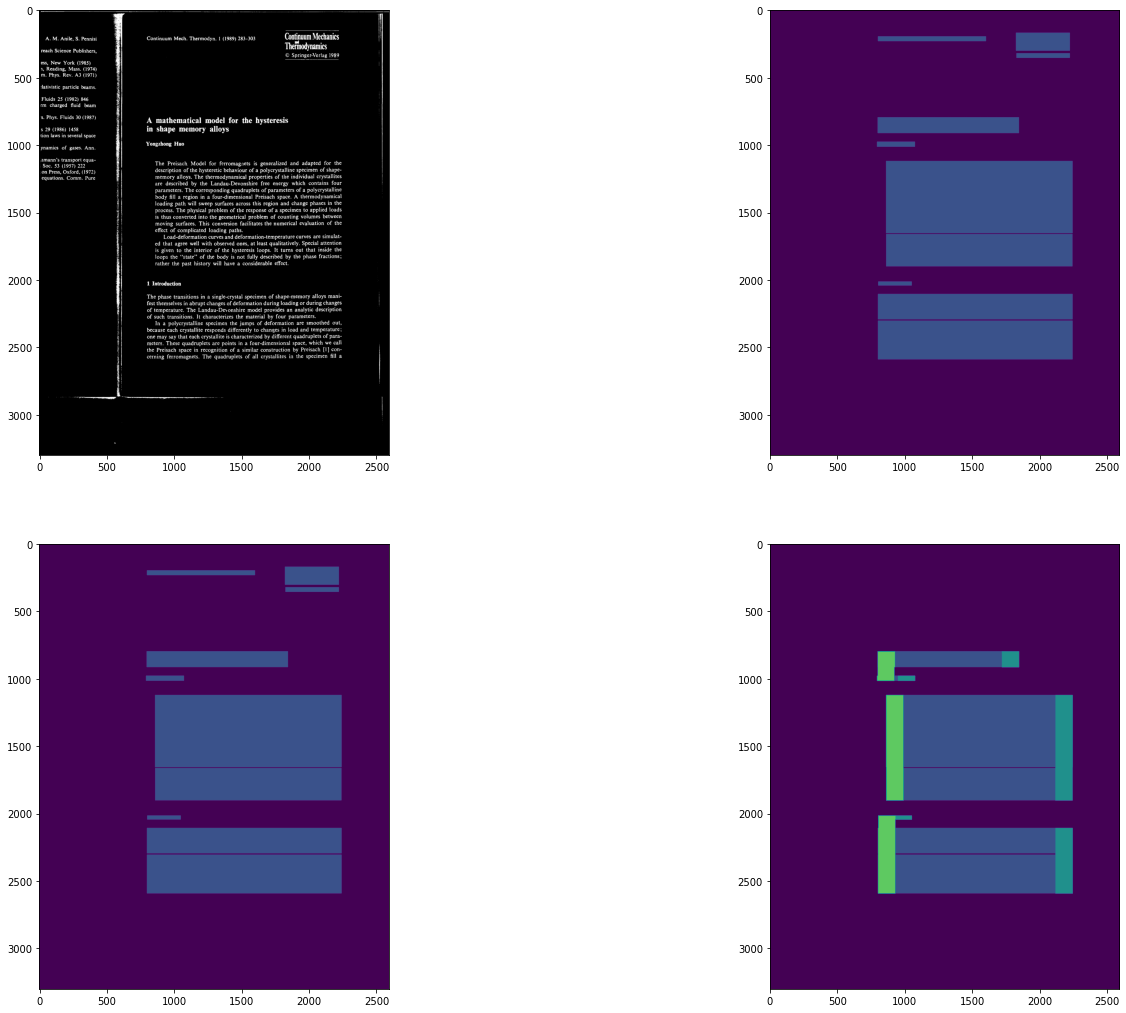

In [110]:
sample = next(source)
figsize(24, 18)
subplot(221); imshow(sample["rawpage.png"])
print(np.amin(sample["zones.png"]), np.amax(sample["zones.png"]))
subplot(222); imshow(sample["zones.png"][...,0], vmin=0, vmax=4)
subplot(223); imshow(sample["cols.png"][...,0], vmin=0, vmax=4)
subplot(224); imshow(sample["boundaries.png"][...,0], vmin=0, vmax=4)

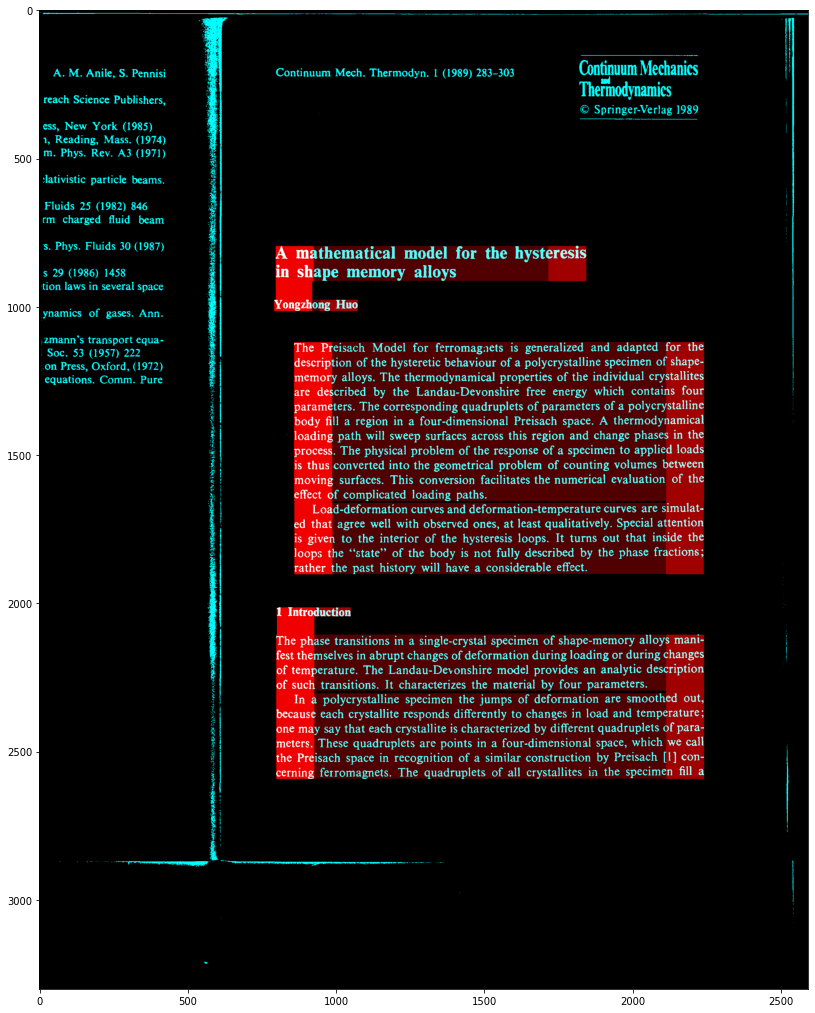

In [111]:
imshow(np.array([80*sample["boundaries.png"][...,0], sample["rawpage.png"][...,0],sample["rawpage.png"][...,0]]).transpose(1, 2, 0) , vmin=0, vmax=4)

# Create Segmentation Ground Truth Images

In [ ]:
sink = wds.TarWriter("uw3/uw3-wordseg-markers.tar")
for i, sample in enumerate(wds.Dataset("uw3/uw3-boxes.tar").decode()):
    if i%100==0: print(i, sample["__key__"])
    image = sample["page.png"]
    #print(image.shape, amin(image), amax(image))
    bboxes = [s["box"] for s in sample["words.json"]]
    wordseg = extract_seg.marker_segmentation_target_for_bboxes(image, bboxes, inside=3)
    sink.write({
        "__key__": sample["__key__"],
        "image.png": image,
        "wordseg.png": wordseg,
    })
sink.close()

In [ ]:
figsize(18, 9)
subplot(121); imshow(image[1000:1500,1000:1500])
subplot(122); imshow(wordseg[1000:1500,1000:1500])

In [ ]:
sink = wds.TarWriter("uw3/uw3-wordseg-markers-masked.tar")
dilate = 20
for i, sample in enumerate(wds.Dataset("uw3/uw3-boxes.tar").decode()):
    if i%100==0: print(i, sample["__key__"])
    image = sample["page.png"]
    #print(image.shape, amin(image), amax(image))
    bboxes = [s["box"] for s in sample["words.json"]]
    wordseg = extract_seg.marker_segmentation_target_for_bboxes(image, bboxes, inside=3)
    mask = (wordseg > 0).astype(np.uint8)
    mask = ndi.maximum_filter(mask, dilate)
    image = image * mask[:, :, newaxis]
    sink.write({
        "__key__": sample["__key__"],
        "image.png": image,
        "mask.png": mask*255,
        "wordseg.png": wordseg,
    })
sink.close()

In [ ]:
subplot(121); imshow(image)
subplot(122); imshow(mask)

In [ ]:
figsize(18, 9)
subplot(121); imshow(image[1000:1500,1000:1500])
subplot(122); imshow(wordseg[1000:1500,1000:1500])

In [ ]:
sink = wds.TarWriter("uw3/uw3-lineseg-markers.tar")
for i, sample in enumerate(wds.Dataset("uw3/uw3-boxes.tar").decode()):
    if i%100==0: print(i, sample["__key__"])
    image = sample["page.png"]
    #print(image.shape, amin(image), amax(image))
    bboxes = [s["box"] for s in sample["lines.json"]]
    lineseg = extract_seg.marker_segmentation_target_for_bboxes(image, bboxes, inside=3)
    sink.write({
        "__key__": sample["__key__"],
        "image.png": image,
        "lineseg.png": lineseg,
    })
    #break
sink.close()

In [ ]:
figsize(18, 9)
subplot(121); imshow(image[500:1500,500:1500])
subplot(122); imshow(lineseg[500:1500,500:1500])

sink = wds.TarWriter("uw3/uw3-wordseg-markers.tar")
for i, sample in enumerate(wds.Dataset("uw3/uw3-boxes.tar").decode()):
    if i%100==0: print(i, sample["__key__"])
    image = sample["page.png"]
    #print(image.shape, amin(image), amax(image))
    bboxes = [s["box"] for s in sample["words.json"]]
    lineseg = extract_seg.marker_segmentation_target_for_bboxes(image, bboxes)
    sink.write({
        "__key__": sample["__key__"],
        "image.png": image,
        "wordseg.png": lineseg,
    })
    #break
sink.close()

figsize(18, 9)
subplot(121); imshow(image[500:1500,500:1500])
subplot(122); imshow(lineseg[500:1500,500:1500])

# Extract Patches

In [ ]:
ph, pw = 1024, 1024
npatches = 100

In [ ]:
sink = wds.TarWriter("uw3/uw3-lineseg-markers-patches.tar")
for i, (key, image, seg) in enumerate(wds.Dataset("uw3/uw3-lineseg-markers.tar")
                                      .decode("l8")
                                      .to_tuple("__key__ image.png lineseg.png")):
    if i%100==0:
        print(i, key)
    assert image.ndim==2
    assert image.shape[:2] == seg.shape, (image.shape, seg.shape)
    h, w = image.shape
    count = 0
    for j in range(10000):
        if count >= npatches: break
        y, x = randrange(0, h-ph), randrange(0, w-pw)
        spatch = seg[y:y+ph, x:x+pw]
        badpatch = (spatch==2).sum() < 10 or (spatch==1).sum() < 10
        if badpatch and uniform() > 0.03: continue
        ipatch = image[y:y+ph, x:x+pw]
        result = {
            "__key__":  f"{key}-{count}",
            "ipatch.png": ipatch,
            "spatch.png": spatch
        }
        sink.write(result)
        count += 1
sink.close()

In [ ]:
sink = wds.TarWriter("uw3/uw3-wordseg-markers-patches.tar")
for i, (key, image, seg) in enumerate(wds.Dataset("uw3/uw3-wordseg-markers.tar")
                                      .decode("l8")
                                      .to_tuple("__key__ image.png wordseg.png")):
    if i%100==0:
        print(i, key)
    assert image.ndim==2
    assert image.shape[:2] == seg.shape, (image.shape, seg.shape)
    h, w = image.shape
    count = 0
    for j in range(10000):
        if count >= npatches: break
        y, x = randrange(0, h-ph), randrange(0, w-pw)
        spatch = seg[y:y+ph, x:x+pw]
        badpatch = (spatch==2).sum() < 10 or (spatch==1).sum() < 10
        if badpatch and uniform() > 0.03: continue
        ipatch = image[y:y+ph, x:x+pw]
        result = {
            "__key__":  f"{key}-{count}",
            "ipatch.png": ipatch,
            "spatch.png": spatch
        }
        sink.write(result)
        count += 1
sink.close()

In [ ]:
sink = wds.TarWriter("uw3/uw3-wordseg-markers-masked-patches.tar")
for i, (key, image, seg) in enumerate(wds.Dataset("uw3/uw3-wordseg-markers-masked.tar")
                                      .decode("l8")
                                      .to_tuple("__key__ image.png wordseg.png")):
    if i%100==0:
        print(i, key)
    assert image.ndim==2
    assert image.shape[:2] == seg.shape, (image.shape, seg.shape)
    h, w = image.shape
    count = 0
    for j in range(10000):
        if count >= npatches: break
        y, x = randrange(0, h-ph), randrange(0, w-pw)
        spatch = seg[y:y+ph, x:x+pw]
        badpatch = (spatch==2).sum() < 10 or (spatch==1).sum() < 10
        if badpatch and uniform() > 0.03: continue
        ipatch = image[y:y+ph, x:x+pw]
        result = {
            "__key__":  f"{key}-{count}",
            "ipatch.png": ipatch,
            "spatch.png": spatch
        }
        sink.write(result)
        count += 1
sink.close()

In [ ]:
!rm -f uw3/uw3-wordseg-markers-patches-*.tar
!tarp cat -s 20000 uw3/uw3-wordseg-markers-patches.tar -o - | tarp split - -s 5e8 -o uw3/uw3-wordseg-markers-patches-%06d.tar

In [ ]:
!rm -f uw3/uw3-lineseg-markers-patches-*.tar
!tarp cat -s 20000 uw3/uw3-lineseg-markers-patches.tar -o - | tarp split - -s 5e8 -o uw3/uw3-lineseg-markers-patches-%06d.tar

In [ ]:
!rm -f uw3/uw3-wordseg-markers-patches-*.tar
!tarp cat -s 20000 uw3/uw3-wordseg-markers-masked-patches.tar -o - | tarp split - -s 5e8 -o uw3/uw3-wordseg-markers-masked-patches-%06d.tar

In [ ]:
#sink = wds.TarWriter("uw3/uw3-temp.tar")
for i, sample in enumerate(wds.Dataset("uw3/uw3-boxes.tar").decode()):
    break

In [ ]:
sample.keys()

In [ ]:
sample["lines.json"]

In [ ]:
for i, sample in enumerate(wds.Dataset("uw3/uw3-original.tar").decode()):
    break
sample.keys()

In [ ]:
def parse_lboxes(sample):
    r = {}
    result = {}
    for l in sample["linebox.txt"].strip().split("\n")[1:] + ["LLLLL"]:
        #print("#", l)
        if l=="LLLLL":
            assert r["ZONE_ID"] not in result
            result[r["ZONE_ID"]] = r
            r = {}
            continue
        k, v = [s.strip() for s in l.split("=", 1)]
        if k == "TEXT_LINE_BOX":
            r.setdefault("lboxes", []).append(tuple(int(x) for x in v.split()))
        else:
            r[k] = v
    return result
parse_lboxes(sample)

In [ ]:
def parse_gt(sample):
    r = {}
    result = {}
    lines = sample["1ground.txt"].strip().split("\n") + ["GGGGG"]
    while len(lines) > 0:
        assert lines[0] == "GGGGG"
        if len(lines) == 1:
            break
        doc = lines[1]
        zone = lines[2]
        gt = []
        del lines[:3]
        while lines[0] != "GGGGG":
            gt.append(lines[0])
            del lines[0]
        result[zone] = dict(DOCUMENT_ID=doc, ZONE_ID=zone, gt=gt)
    return result
parse_gt(sample)

In [ ]:
gt = parse_gt(sample)
bb = parse_lboxes(sample)
result = []
for zone in gt.keys():
    assert zone in bb
    assert gt[zone]["DOCUMENT_ID"] == bb[zone]["DOCUMENT_ID"]
    assert gt[zone]["ZONE_ID"] == bb[zone]["ZONE_ID"]
    textlines = gt[zone]["gt"]
    boxes = bb[zone]["lboxes"]
    assert len(textlines) == len(boxes)
    for txt, bbox in zip(textlines, boxes):
        r = dict(
            doc=gt[zone]["DOCUMENT_ID"],
            zone=gt[zone]["ZONE_ID"],
            bbox=bbox,
            txt=txt
        )
        result.append(r)

In [ ]:
image = np.array(PIL.Image.open(io.BytesIO(sample["image.tif"])))

In [ ]:
x0, y0, x1, y1 = result[20]["bbox"]
imshow(image[y0:y1, x0:x1])